In [2]:
import geomstats
import geomstats.backend as gs
from geomstats.geometry.spd_matrices import *
from geomstats.geometry.stiefel import Stiefel
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
from shape_vis import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla

# Learning distributions of healthy & schizophrenic brain shapes via denoising diffusion on manifolds
## Authors: Marianne Arriola and Ryan Stofer

(*Ryan*)

According to the WHO, Schizophrenia is classified as a mental disorder which impairs a person's ability to think, feel and behave properly. Schizophrenia currently affects approximately 24 million people or 1 in 300 people (0.32%) worldwide and those who are infected with the disease are 2 to 3 times more likely to die early than the general population [1].

In 2014, the IEEE International Workshop on Machine Learning for Signal Processing created a classification challenge open to the public in an effort to promote model building for diagonising schizophrenia from a patient's brain magnetic resonance imaging (MRI) scan [2]. In this notebook, we plan on advancing their work on identifying schizophrenia by utilizing their Functional Network Connectivity (FNC) data taken from a functional magnetic resonance imaging (fMRI) of both schizophrenic and healthy patients to learn distributions of healthy and schizophrenic brain shapes via denoising diffusion on manifolds.

(*Marianne*)

We experimentally demonstrate that there exists large variations in brain network behavior from individual to individual. Learning distributions of healthy and schizophrenic brain shapes has impactful implications because it will enable researchers to generalize brain behavior in order to distinguish meaningful patterns that aren't due to noise or individual bias. We aim to learn these distributions by learning distributions over a symmetric positive definite (SPD) manifold.

Learning distributions over data has recently been of great interest in generative modeling. Ho et. al proposed an approach to image generation by training a neural network to transform noisy images to clean images in the training set [3]. This approach, termed denoising diffusion, enables the neural network to learn a mapping from noisy data distributions to clean distributions over a given dataset. This has also recently been applied to geometry: Vignac et. al extended this approach to learn distributions over networks and applied it to learn distributions over molecular graphs [4]. The authors propose a neural network to learn node-wise and edge-wise probabilities in the training set. Martinkus et. al have approached the graph generation problem by performing gradient descent on samples taken from a Stiefiel manifold to generate graph eigenvectors [5]. However, the authors do not leverage the underlying manifold structure in designing a neural network to navigate the manifold. They instead perform matrix operations to ensure the generated eigenvectors remain on the manifold.

We propose to apply denoising diffusion in designing a neural network to learn distributions over manifolds. We test this to learn distributions of brain connectivity over a manifold of SPD matrices, though we aim to demonstrate that this approach can be extended to learn distributions over arbitrary manifolds.

# Loading data

(*Marianne*)

We begin by first loading in our data, which is composed of 86 samples containing 28 by 28 brain functional connectivity matrices:

In [3]:
data, ids, target = load_connectomes()
schiz_ids,healthy_ids=np.where(np.array(target==1))[0],np.where(np.array(target==0))[0]
print('shape',data.shape)
print(np.where(np.array(target==1))[0].shape[0],'schizophrenic samples and',np.where(np.array(target==0))[0].shape[0],'healthy samples')

shape (86, 28, 28)
40 schizophrenic samples and 46 healthy samples


### Manifold of connectomes
(*Ryan & Marianne*)

Using the `.belongs()` method from the `geomstats` package, we are able to see which manifold our data belongs to. In the following code chunk, we see that each $28 \times 28$ matrix belongs to the Symmetric Positive Definite (SPD) manifold and not the Stiefel manifold.

In [4]:
# show that connectomes belong to manifold of spd matrices
spd = SPDMatrices(28)
spd_affine_bures_wasserstein = SPDBuresWassersteinMetric(28)
stiefel = Stiefel(28,1)
print('Does it belong to SPD?',spd.belongs(data))

Does it belong to SPD? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


### Processing samples
(*Marianne & Ryan*)

Furthermore, we introduce two metrics, Affine Invariant Riemannian metric and Log-Euclidean, which are two common metrics that are used when computing with SPD data.

In [5]:
# If you want to implement more metrics, go ahead and use these 
# (Prof Miolane said it would be a good idea to include some more)
ai_metric = SPDAffineMetric(28)
le_metric = SPDLogEuclideanMetric(28)

We also split our data based on whether the patient has schizophrenia or is a part of the healthy control group. Furthermore, we project our data onto the SPD manifold by using the `.projection()` method.

In [6]:
bool_list = list(map(bool,target))
schiz = data[bool_list]
print(schiz.shape)
schiz_spd = spd.projection(schiz)

(40, 28, 28)


In [7]:
flip_bool_list = [not elem for elem in bool_list]
healthy = data[flip_bool_list]
print(healthy.shape)
healthy_spd = spd.projection(healthy)

(46, 28, 28)


## Visualizing variations in schizophrenic and healthy brain connectivity

### SPD matrix analysis
(*Ryan & Marianne*)

We now compute the Bures-Wasserstein squared distance between each combination of a healthy and schizophrenic patient and plot out its distribution. We notice that there is a noticeable bell-like curve with the values centered around 4.

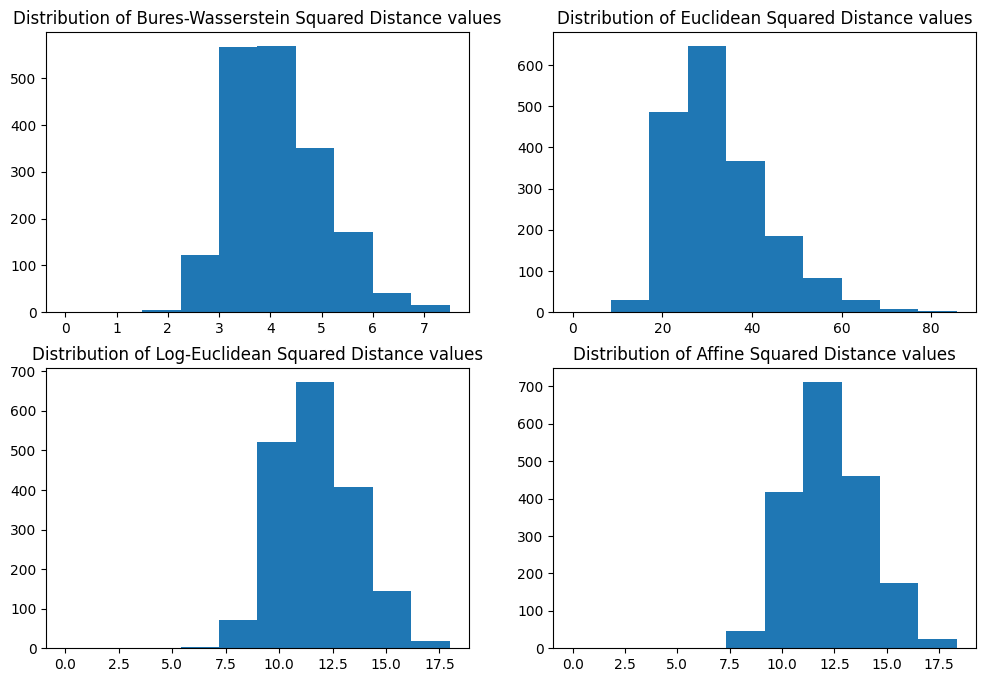

In [8]:
sqrd_dist_bw = compute_sqr_dist(SPDBuresWassersteinMetric,healthy_spd, schiz_spd, 28)
sqrd_dist_e = compute_sqr_dist(SPDEuclideanMetric,healthy_spd, schiz_spd, 28)
sqrd_dist_le = compute_sqr_dist(SPDLogEuclideanMetric,healthy_spd, schiz_spd, 28)
sqrd_dist_a = compute_sqr_dist(SPDAffineMetric,healthy_spd, schiz_spd, 28)

fig = plt.figure(figsize=(12, 8))
plot_sqr_dists(sqrd_dist_bw,221,"Distribution of Bures-Wasserstein Squared Distance values")
plot_sqr_dists(sqrd_dist_e,222,"Distribution of Euclidean Squared Distance values")
plot_sqr_dists(sqrd_dist_le,223,"Distribution of Log-Euclidean Squared Distance values")
plot_sqr_dists(sqrd_dist_a,224,"Distribution of Affine Squared Distance values")
plt.show()

(*Ryan*)

We plot out an example SPD matrix of both a healthy and schizophrenic brain's FNC correlation matrix.

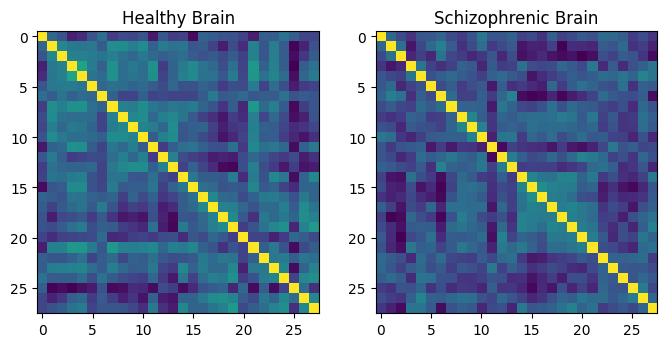

In [9]:
labels_str = ["Healthy Brain", "Schizophrenic Brain"]

fig = plt.figure(figsize=(8, 4))
plot_SPD_image(data[0], 122, labels_str[target[0]])
plot_SPD_image(data[1], 121, labels_str[target[1]])
plt.show()

We now plot out the average FNC correlation matrices for both a healthy brain and a schizophrenic brain.

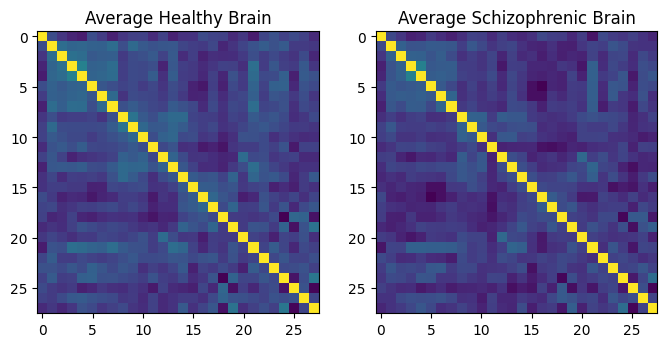

In [10]:
ave_schiz = np.sum(schiz_spd, axis = 0)/len(schiz[0])
ave_healthy = np.sum(healthy_spd, axis = 0)/len(healthy[0])

fig = plt.figure(figsize=(8, 4))
plot_SPD_image(ave_healthy, 121, 'Average Healthy Brain')
plot_SPD_image(ave_schiz, 122, 'Average Schizophrenic Brain')
plt.show()

We now compute the Riemannian logarithm based on the schizophrenic SPD matrix with respect to the Bures-Wasserstein metric. This produces a tangent vector at the schizophrenic SPD matrix. We then plot out 4 random images of the (1480) log vectors for visualization.

In [11]:
log_vec = compute_log(healthy_spd, schiz_spd, 28)

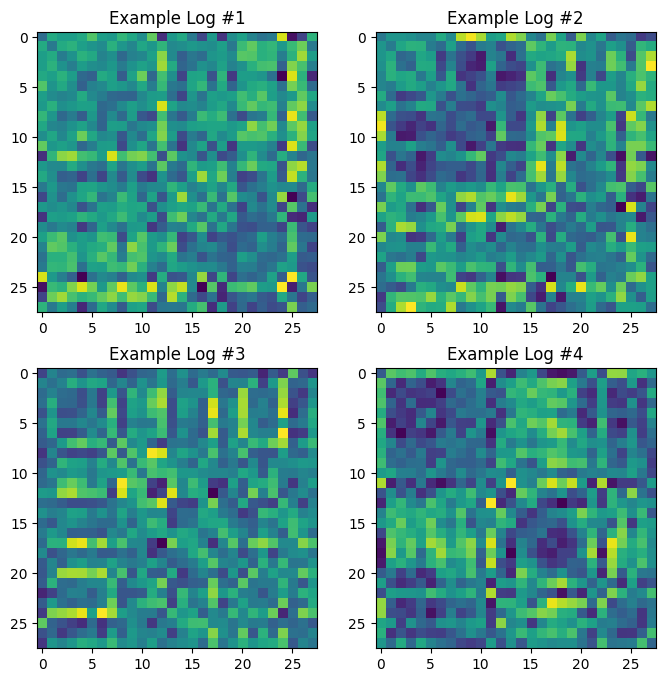

In [12]:
random_vecs = np.random.randint(log_vec.shape[0], size=4)
plt.figure(figsize=(8,8))
plot_SPD_image(log_vec[random_vecs[0]], 221, 'Example Log #1')
plot_SPD_image(log_vec[random_vecs[1]], 222, 'Example Log #2')
plot_SPD_image(log_vec[random_vecs[2]], 223, 'Example Log #3')
plot_SPD_image(log_vec[random_vecs[3]], 224, 'Example Log #4')
plt.show()

### Spatial comparison
(*Marianne*)

We visualize the connectivity information of the healthy and schizophrenic brain data by representing the SPD matrices as graphs where each node corresponds to a brain region and each edge corresponds to strong functional correlation. We demonstrate that there are differences in the graph toplogy not only between healthy and schizophrenic brain networks, but there are also variations between brain networks in the same patient group. As shown below, the brightness of the node color corresponds to the degree of each node such that nodes (or brain regions) that are highly connected (or highly correlated) to the rest of the graph are brightly colored and nodes that are sparsely connected are darkly colored.

Notably, although *on average* schizophrenic brain networks are less densely clustered than healthy brain networks as shown by their average clustering coefficients, there are exceptions shown in the plotted samples.

In [13]:
g_schiz1,g_schiz2,g_norm1,g_norm2=get_brain_networks(data,[0,1,2,4])

print('Average cluster coefficient for schizophrenic brain networks:')
print(np.mean(np.array([nx.average_clustering(s) for s in get_brain_networks(data,schiz_ids)])))
print('Average cluster coefficient for healthy brain networks:')
print(np.mean(np.array([nx.average_clustering(s) for s in get_brain_networks(data,healthy_ids)])))

Average cluster coefficient for schizophrenic brain networks:
0.7531341016333422
Average cluster coefficient for healthy brain networks:
0.7872384043489662


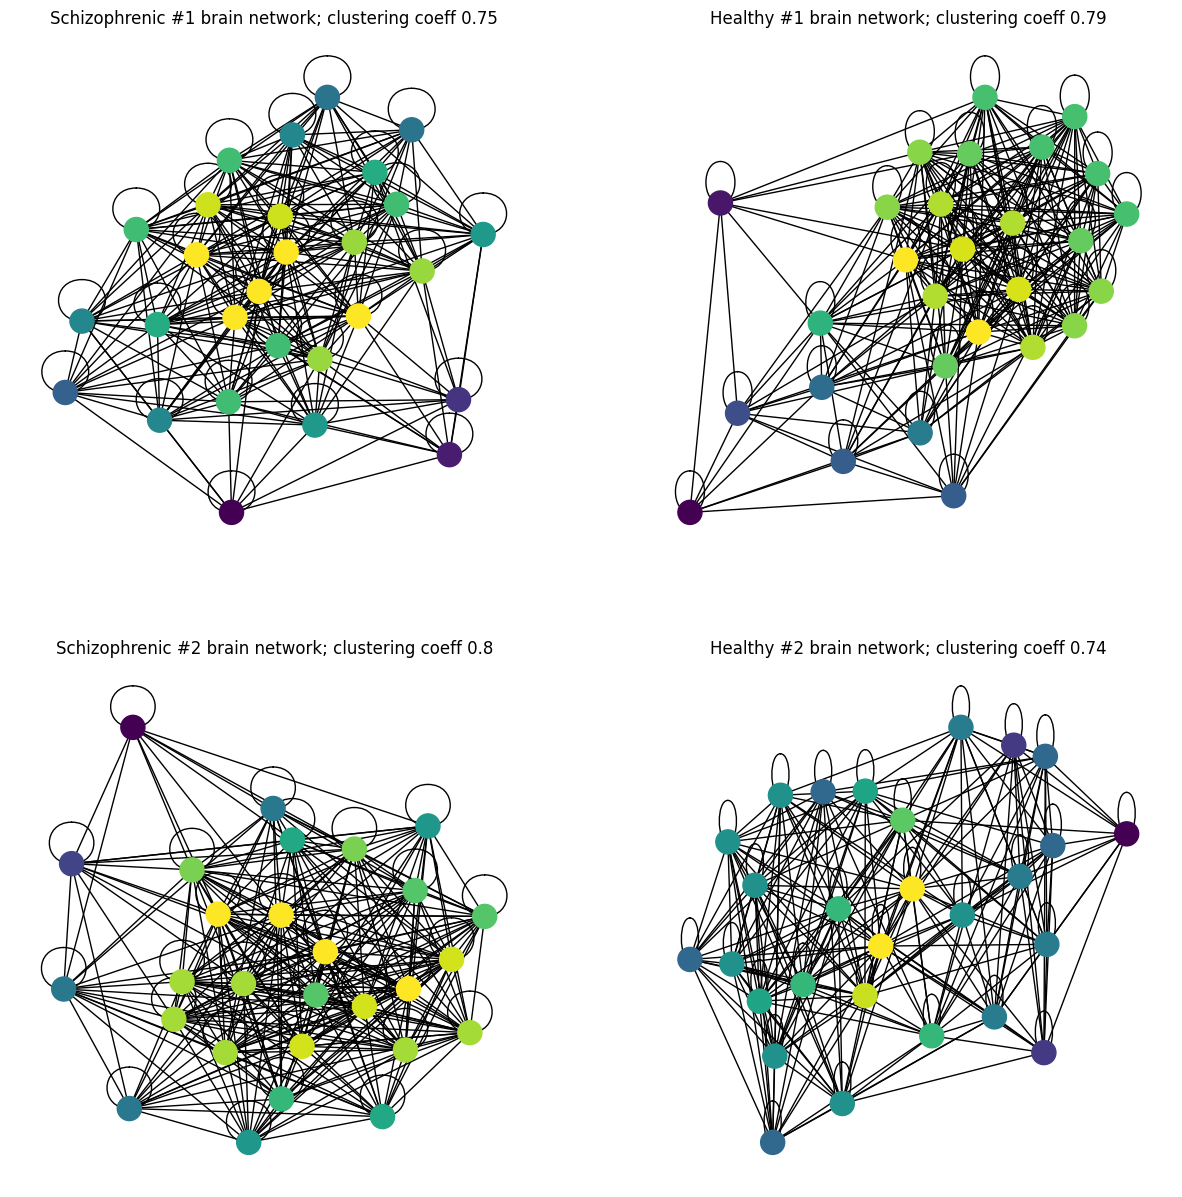

In [14]:
plt.figure(figsize=(15,15))
plot_graphs_spatial(g_schiz1,221,f"Schizophrenic #1 brain network; clustering coeff {round(nx.average_clustering(g_schiz1),2)}")
plot_graphs_spatial(g_norm1,222,f"Healthy #1 brain network; clustering coeff {round(nx.average_clustering(g_norm1),2)}")
plot_graphs_spatial(g_schiz2,223,f"Schizophrenic #2 brain network; clustering coeff {round(nx.average_clustering(g_schiz2),2)}")
plot_graphs_spatial(g_norm2,224,f"Healthy #2 brain network; clustering coeff {round(nx.average_clustering(g_norm2),2)}")
plt.show()

### Spectral comparison
(*Marianne*)

We also analyze the graph spectrum corresponding to the graph Laplacian's eigenvalues and eigenvectors which convey significant information about graph communities. We visualize the distribution of spectral energy to show the variations in the graph spectrum across samples. We visually observe that the spectral energy distributions of the samples have large differences between samples within and across the patient groups.

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


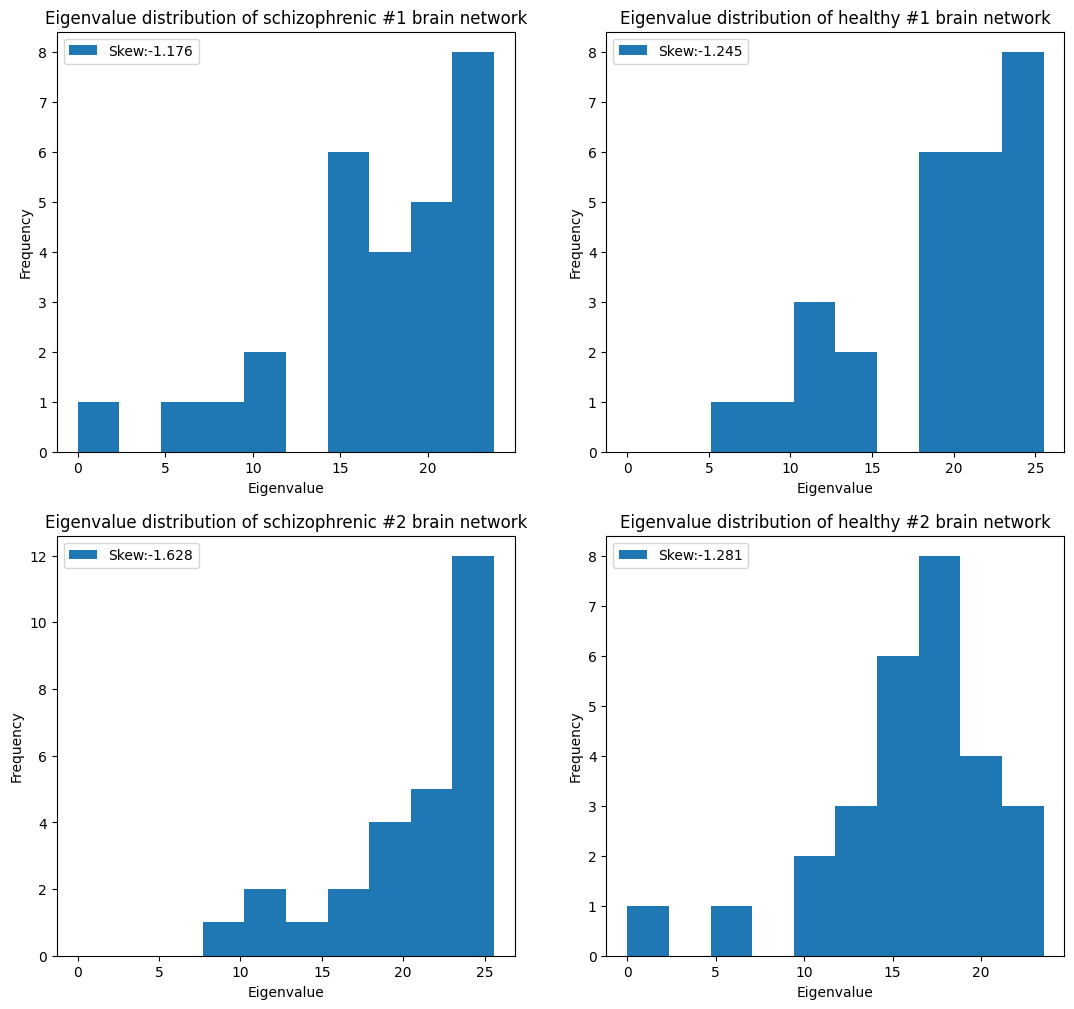

In [15]:
plt.figure(figsize=(13,12))
plot_graphs_spectral(g_schiz1,221,"Eigenvalue distribution of schizophrenic #1 brain network")
plot_graphs_spectral(g_norm1,222,"Eigenvalue distribution of healthy #1 brain network")
plot_graphs_spectral(g_schiz2,223,"Eigenvalue distribution of schizophrenic #2 brain network")
plot_graphs_spectral(g_norm2,224,"Eigenvalue distribution of healthy #2 brain network")
plt.show()

References:

[1] https://www.who.int/news-room/fact-sheets/detail/schizophrenia

[2] https://www.kaggle.com/competitions/mlsp-2014-mri/overview

[3] Jonathan Ho, Ajay Jain, and Pieter Abbeel. Denoising diffusion probabilistic models. In H. Larochelle, M. Ranzato, R. Hadsell, M.F. Balcan, and H. Lin (eds.), Advances in Neural Information Processing Systems, volume 33, pp. 6840–6851. Curran Asso- ciates, Inc., 2020. URL https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf.

[4] Clement Vignac, Igor Krawczuk, Antoine Siraudin, Bohan Wang, Volkan Cevher, and Pascal Frossard. DiGress: Discrete Denoising diffusion for graph generation. In ICLR 2023. URL https://arxiv.org/pdf/2209.14734.pdf

[5] Karolis Martinkus, Andreas Loukas, Nathanael Perraudin, and Roger Wattenhofer. Spectre: Spectral conditioning helps to overcome the expressivity limits of one-shot graph generators. In ICML 2022. URL https://proceedings.mlr.press/v162/martinkus22a/martinkus22a.pdf

[6] Jianheng Tang, Jiajin Li, Zi-Chao Gao, and Jia Li. Rethinking graph neural networks for anomaly detection. In ICML 2022. URL https://arxiv.org/pdf/2205.15508.pdf